In [77]:
from siftdetector import detect_keypoints
%matplotlib inline
from numpy_sift import SIFTDescriptor 
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/ubuntu/dev/opencv-3.1/build/lib')
import cv2
import time
import numpy as np
import cv2
from sklearn.cluster import KMeans
import os
from math import log
from tqdm import tqdm

The following code produces the image seen in Part 1. of the tutorial. It gets the features to track from cv2, iterates through them and plots them in the image.

[[203 204 205 ..., 204 204 204]
 [203 204 205 ..., 204 204 204]
 [203 204 205 ..., 204 204 204]
 ..., 
 [ 87  98  96 ...,  98 108 115]
 [ 94 101  99 ..., 102 109 108]
 [ 99 102 100 ...,  88  91 100]]


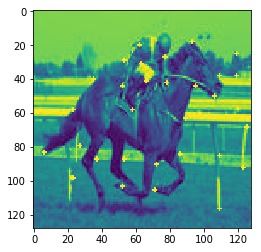

(<matplotlib.image.AxesImage at 0x1170c3fd0>, None)

In [114]:
display_img = cv2.imread('racehorse/00000019.jpg', 0)
display_corners = cv2.goodFeaturesToTrack(display_img,30,0.01,10)
display_corners = np.int0(display_corners)
for i in display_corners:
    x,y = i.ravel()
    cv2.circle(display_img,(x,y),1,255,-1)
plt.imshow(display_img),plt.show()

The code below is explained in the tutorial, it returns the feature vectors of the all the images in the directories listed in directoryList.

In [61]:
def return_labels(directoryList, range_size, added_limit, count_limit, patch_size=32):
    SD = SIFTDescriptor(patchSize = patch_size)

    #creates initial vector of size 3968
    sift_pictures = np.asarray([[0 for _ in range(range_size)]])
    for directory in directoryList:
        #go through the directories with the relevant images
        for filename in os.listdir(directory):
            name = directory + '/' + filename
            if name[-3:] == 'png' or name[-3:] == 'jpg':
                image = cv2.imread(name)
                
                #transform it to black and white and get features
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                h, w = gray.shape
                corners = cv2.goodFeaturesToTrack(gray,count_limit,0.01,10)

                corners = np.int0(corners)
                image_sift_features = np.asarray([]) 
                count, actually_added = 0, 0
                
                #Here we want to get 31 images for our feature vector and then break out of the loop
                while actually_added < added_limit and count < count_limit:
                    corner = corners[count][0]
                    if patch_size/2 <= corner[1] <= h-patch_size/2 and patch_size/2 <= corner[0] <= w-patch_size/2:
                        patch = gray[corner[1]-patch_size/2:corner[1]+patch_size/2, corner[0]-patch_size/2:corner[0]+patch_size/2]
                        sift = SD.describe(patch)
                        image_sift_features = np.append(image_sift_features, sift)
                        actually_added += 1
                    count += 1

                sift_pictures = np.append(sift_pictures, [image_sift_features], axis=0)

    return sift_pictures[1:]


In [115]:
sift_pictures = return_labels(['abbey', 'racehorse'], 3968, 31, 100)
kmeans = KMeans(n_clusters=2, random_state=1).fit(sift_pictures)
test_pictures = return_labels(['test'], 3968, 31, 100)
print kmeans.predict(sift_pictures)
print kmeans.predict(test_pictures)


[1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
[1 1 1 0 0 1]


The 0s and 1s correspond to which cluster KMeans is putting the images in. We can manually check that it is correctly or incorrectly classifying the images. It doesn't matter which cluster KMeans puts an image in, just that it is putting abbey images (the first 21 images) and racecar images (the next 15 images) in different clusters. As it turns out, we classified 30/36 of our original images correctly and 5/6 of our test images correctly, not bad!

In [ ]:
[1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
[1 1 1 0 0 1]

This is the code that generates picture in Part II in the tutorial.

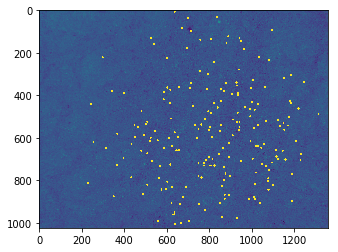

(<matplotlib.image.AxesImage at 0x1029ab1d0>, None)

In [110]:
#PR_20081014_014133_663_LC16
#display_img = cv2.imread('seaweed/PR_20081014_010133_346_LC16.png', 0)
display_img = cv2.imread('sand/PR_20081014_014133_663_LC16.png', 0)
display_corners = cv2.goodFeaturesToTrack(display_img,200,0.01,10)
display_corners = np.int0(display_corners)
for i in display_corners:
    x,y = i.ravel()
    cv2.circle(display_img,(x,y),5,255,-1)
plt.imshow(display_img),plt.show()

This code clusters the images from the seaweed and sand files.

In [59]:
naive_sift_pictures = return_labels(['seaweed', 'sand'], 38400, 300, 1000, 1000)
naive_kmeans = KMeans(n_clusters=2, random_state=1).fit(naive_sift_pictures)
print naive_kmeans.predict(naive_sift_pictures)

[1 1 1 1 1 0 1 1 1 1 1]


This code implements the information in the HUE section of Part II.

In [117]:
def hue_features(directoryList, range_size, added_limit, count_limit, patch_size=32):

    SD = SIFTDescriptor(patchSize = patch_size)
    sift_pictures = np.asarray([[0 for _ in range(range_size)]])
    #go through the directories sand and seaweed
    for directory in ['sand', 'seaweed']:
        for filename in os.listdir(directory):
            name = directory + '/' + filename
            if name[-3:] == 'png' or name[-3:] == 'jpg':
                image = cv2.imread(name)
                #convert image into HSV space and get just the Hue in variable HR
                hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                pixels = hsv.reshape((hsv.shape[0], hsv.shape[1], 3))
                H, S, V = pixels.T
                HR = H.T
                
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                #get corner features as before
                corners = cv2.goodFeaturesToTrack(gray, count_limit, 0.01,10)
                corners = np.int0(corners)

                image_sift_features = np.asarray([]) 
                count, actually_added = 0, 0

                while actually_added < added_limit and count < count_limit:
                    corner = corners[count][0]
                    if 16 <= corner[1] <= 1008 and 16 <= corner[0] <= 1344:
                        patch = gray[corner[1]-16:corner[1]+16, corner[0]-16:corner[0]+16]
                        #get the value of our new feature, the average hue value in the patch
                        color = np.average(HR[corner[1]-16:corner[1]+16, corner[0]-16:corner[0]+16])
                        sift = SD.describe(patch)
                        #append the new feature 150 time
                        sift = np.append(sift, [color for _ in range(50)])
                        image_sift_features = np.append(image_sift_features, sift)
                        actually_added += 1
                    count += 1

                sift_pictures = np.append(sift_pictures, [image_sift_features], axis=0)

    return sift_pictures[1:]
      

In [119]:
hue_sift_pictures = hue_features(['seaweed', 'sand'], 83400, 300, 1000)
hue_kmeans = KMeans(n_clusters=2, random_state=1).fit(hue_sift_pictures)
print hue_kmeans.predict(hue_sift_pictures)

[1 1 1 1 1 1 1 1 1 0 1]


This time our classification scheme did much better, making only two errors.

This function implements the entropy explained in Part II of the tutorial. NOTE:  The following code will take several minutes to run! This is expected.

In [116]:
#This funtion is calcuating the entropy using the equations above and returns the 'value' highest corner points
def get_max(corners, h, w, patch_size, gray, value=10):
    entropy_points = {}
    for corner in corners:
        x, y = corner[0]
        entropy = 0
        if (patch_size/2) <= y <= h-(patch_size/2) and (patch_size/2) <= x <= w-(patch_size/2):
            for row in range(x-4, x+4):
                for col in range(y-4, y+4):
                    #this line is counting up all the locations where the pixels are the same
                    entropy += len(np.where(gray==gray[col][row])[0])
            entropy_points[(x,y)] = -log(float(entropy)/(h*w))/64
    return sorted(entropy_points.items(), key=lambda x: entropy_points[x[0]], reverse=True)[:value]


def entropy_features(directoryList, range_size, count_limit, patch_size=64):
    SD = SIFTDescriptor(patchSize = patch_size)
    sift_pictures = np.asarray([[0 for _ in range(range_size)]])
    count = 1
    for directory in ['sand', 'seaweed']:
        for filename in os.listdir(directory):
            name = directory + '/' + filename
            if name[-3:] == 'png' or name[-3:] == 'jpg':
                print str(count) + "/11 finished"
                image = cv2.imread(name, 0)
                h,w = image.shape
                corners = cv2.goodFeaturesToTrack(image,count_limit,0.01,10)
                image_sift_features = np.asarray([]) 
                corners = np.int0(corners)
                highest_entropy = get_max(corners, h, w, patch_size, image)
                for point in highest_entropy:
                    point = point[0]
                    patch = image[point[1]-32:point[1]+32, point[0]-32:point[0]+32]
                    sift = SD.describe(patch)
                    image_sift_features = np.append(image_sift_features, sift)
                sift_pictures = np.append(sift_pictures, [image_sift_features], axis=0)
                
                count += 1
    
    return sift_pictures[1:]


In [106]:
entropy_sift_pictures = entropy_features(['seaweed', 'sand'], 1280, 100)
entropy_kmeans = KMeans(n_clusters=2, random_state=1).fit(entropy_sift_pictures)
print entropy_kmeans.predict(entropy_sift_pictures)

1/11 finished
2/11 finished
3/11 finished
4/11 finished
5/11 finished
6/11 finished
7/11 finished
8/11 finished
9/11 finished
10/11 finished
11/11 finished
[0 0 0 0 0 0 0 0 1 0 0]


Although the entropy code did not have as much impact on the accuracy as the hue did, saliency is an important concept to understand when talking about image classification in unstructured environments!